Generation 1 - Best Fitness: 4.696 - Avg Fitness: 3.915
Generation 11 - Best Fitness: 4.808 - Avg Fitness: 4.465
Generation 21 - Best Fitness: 4.856 - Avg Fitness: 4.477
Generation 31 - Best Fitness: 4.832 - Avg Fitness: 4.489
Generation 41 - Best Fitness: 4.840 - Avg Fitness: 4.485


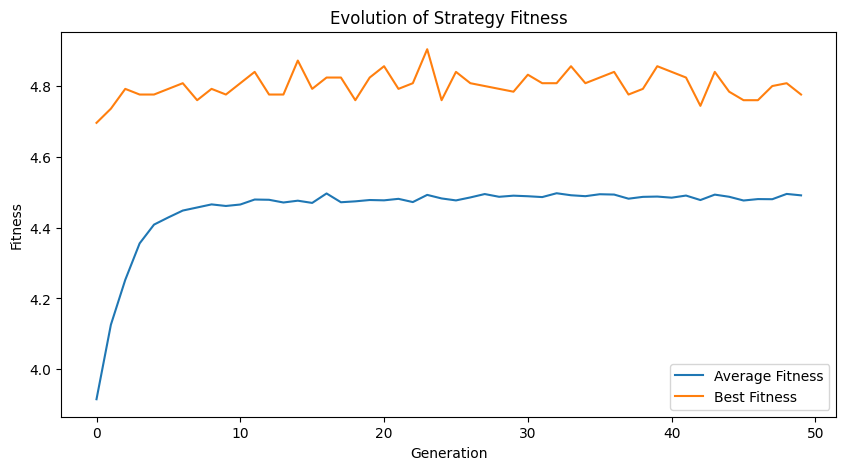

#1 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'D', 'D']}, Fitness: 5.000
#2 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'C', 'D']}, Fitness: 5.000
#3 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'D', 'D']}, Fitness: 5.000
#4 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D']}, Fitness: 5.000
#5 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'C', 'D']}, Fitness: 5.000
Best overall solution found in Generation 24 with Fitness: 4.904
Best evolved strategy genome: ['D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D']


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Strategy Classes
# ==========================

class Strategy:
    """Base class for all strategies."""
    def make_move(self, history):
        raise NotImplementedError

class AlwaysCooperate(Strategy):
    def make_move(self, history):
        return "C"

class AlwaysDefect(Strategy):
    def make_move(self, history):
        return "D"

class Alternator(Strategy):
    def __init__(self):
        self.last_move = "D"

    def make_move(self, history):
        self.last_move = "C" if self.last_move == "D" else "D"
        return self.last_move

class TitForTat(Strategy):
    def make_move(self, history):
        return "C" if not history else history[-1][1]

class GrimTrigger(Strategy):
    def __init__(self):
        self.defected = False

    def make_move(self, history):
        if self.defected:
            return "D"
        if history and history[-1][1] == "D":
            self.defected = True
            return "D"
        return "C"

class SuspiciousTitForTat(Strategy):
    def make_move(self, history):
        return "D" if not history else history[-1][1]

class Pavlov(Strategy):
    def make_move(self, history):
        if not history:
            return "C"
        last_own, last_opponent = history[-1]
        return last_own if last_own == last_opponent else ("C" if last_own == "D" else "D")

# ==========================
# Prisoner's Dilemma Simulation
# ==========================

def play_ipd(strategy1, strategy2, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    score1, score2 = 0, 0
    history = []
    for _ in range(rounds):
        move1 = decide_move(strategy1, history, memory_length, player_idx=1)
        move2 = decide_move(strategy2, history, memory_length, player_idx=2)
        
        # Inject noise: flip each move with probability noise_prob if noise is enabled.
        if noise:
            if random.random() < noise_prob:
                move1 = "D" if move1 == "C" else "C"
            if random.random() < noise_prob:
                move2 = "D" if move2 == "C" else "C"
        
        s1, s2 = payoff(move1, move2)
        score1 += s1
        score2 += s2
        history.append((move1, move2))
        if len(history) > memory_length:
            history.pop(0)
    return score1, score2


def decide_move(strategy, shared_history, memory_length, player_idx):
    perspective = []
    for (m1, m2) in shared_history:
        perspective.append((m1, m2)) if player_idx == 1 else perspective.append((m2, m1))
    if isinstance(strategy, Strategy):
        return strategy.make_move(perspective)
    else:
        index = strategy_lookup(perspective, memory_length)
        return strategy["genome"][index]

def strategy_lookup(history, memory_length):
    if len(history) < memory_length:
        return 0
    relevant = history[-memory_length:]
    binary_str = "".join("1" if move == "C" else "0"
                         for round_moves in relevant for move in round_moves)
    return int(binary_str, 2) + 1

def payoff(move1, move2):
    PAYOFF_MATRIX = {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 5),
        ("D", "C"): (5, 0),
        ("D", "D"): (1, 1)
    }
    return PAYOFF_MATRIX[(move1, move2)]

# ==========================
# Genetic Algorithm Components
# ==========================

def initialize_population(pop_size, memory_length):
    genome_size = 2 ** (2 * memory_length) + 1
    population = []
    for _ in range(pop_size):
        individual = {
            "type": "binary",
            "genome": [random.choice(["C", "D"]) for _ in range(genome_size)]
        }
        population.append(individual)
    return population

def fitness(strategy, opponents, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    total_score = 0
    max_possible_score = rounds * 5
    for opponent in opponents:
        score1, _ = play_ipd(strategy, opponent, rounds, memory_length, noise, noise_prob)
        total_score += score1
    normalized_fitness = total_score / (len(opponents) * max_possible_score)
    return 1 + 4 * normalized_fitness

def mutate(strategy):
    # Flip each gene with a small fixed probability.
    genome = strategy["genome"].copy()
    for i in range(len(genome)):
        if random.random() < 0.1:
            genome[i] = "C" if genome[i] == "D" else "D"
    return {"type": "binary", "genome": genome}

def crossover(parent1, parent2):
    genome1, genome2 = parent1["genome"], parent2["genome"]
    split = random.randint(1, len(genome1) - 1)
    child1 = {"type": "binary", "genome": genome1[:split] + genome2[split:]}
    child2 = {"type": "binary", "genome": genome2[:split] + genome1[split:]}
    return child1, child2

def tournament_selection(population, fitness_scores, tournament_size=8):
    selected_parents = []
    for _ in range(len(population) // 2):
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = max(tournament, key=lambda pair: pair[1])
        selected_parents.append(winner[0])
    return selected_parents

def genetic_algorithm(pop_size=100, generations=100, mutation_rate=0.1, crossover_rate=0.2,
                      rounds=100, memory_length=2, opponents=None, tournament_size=3, noise=False, noise_prob=0.1): 
    # Use a diverse set of opponents to avoid overfitting.
    if opponents is None:
        opponents = [
            AlwaysCooperate(), AlwaysDefect(), Alternator(),
            TitForTat(), GrimTrigger(), SuspiciousTitForTat(), Pavlov()
        ]
    
    population = initialize_population(pop_size, memory_length)
    avg_fitness_progression = []
    best_fitness_progression = []

    # Variables to track the best overall solution and its generation.
    best_overall_fitness = -float('inf')
    best_overall_strategy = None
    best_overall_generation = -1

    for generation in range(generations):
        fitness_scores = [fitness(ind, opponents, rounds, memory_length, noise, noise_prob) for ind in population]
        avg_fit = np.mean(fitness_scores)
        best_fit = max(fitness_scores)
        avg_fitness_progression.append(avg_fit)
        best_fitness_progression.append(best_fit)

        # Track the generation when a new best solution is found.
        current_best_idx = np.argmax(fitness_scores)
        if fitness_scores[current_best_idx] > best_overall_fitness:
            best_overall_fitness = fitness_scores[current_best_idx]
            best_overall_strategy = population[current_best_idx]
            best_overall_generation = generation + 1  # +1 for 1-indexed generation

        if generation % 10 == 0:
            print(f"Generation {generation + 1} - Best Fitness: {best_fit:.3f} - Avg Fitness: {avg_fit:.3f}")

        # Tournament selection returns half the population as parents.
        parents = tournament_selection(population, fitness_scores, tournament_size)
        offspring = []

        for i in range(0, len(parents) - 1, 2):
            p1, p2 = parents[i], parents[i+1]
            if random.random() < crossover_rate:
                child1, child2 = crossover(p1, p2)
            else:
                child1, child2 = p1.copy(), p2.copy()

            if random.random() < mutation_rate:
                child1 = mutate(child1)
            if random.random() < mutation_rate:
                child2 = mutate(child2)

            offspring.append(child1)
            offspring.append(child2)

        # Combine parents and offspring, then trim to the original pop_size.
        population = parents + offspring
        population = population[:pop_size]

        # Elitism: Ensure the best individual survives to the next generation.
        best_individual = max(zip(population, fitness_scores), key=lambda pair: pair[1])[0]
        population[0] = best_individual

    # Plot fitness over generations.
    plt.figure(figsize=(10, 5))
    plt.plot(avg_fitness_progression, label="Average Fitness")
    plt.plot(best_fitness_progression, label="Best Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Strategy Fitness")
    plt.legend()
    plt.show()

    final_fitness_scores = [fitness(ind, opponents, rounds, memory_length) for ind in population]
    sorted_pop = sorted(zip(population, final_fitness_scores), key=lambda x: x[1], reverse=True)
    best_strategies = sorted_pop[:5]

    for i, (strat, score) in enumerate(best_strategies, start=1):
        print(f"#{i} Strategy: {strat}, Fitness: {score:.3f}")

    print(f"Best overall solution found in Generation {best_overall_generation} with Fitness: {best_overall_fitness:.3f}")
    return best_overall_strategy

# ==========================
# Main Execution Example
# ==========================

if __name__ == "__main__":
    # opponents = [
    #     AlwaysCooperate(), AlwaysDefect(), Alternator(),
    #     TitForTat(), GrimTrigger(), SuspiciousTitForTat(), Pavlov()
    # ]
    opponents = [AlwaysCooperate()]
    best_strategy = genetic_algorithm(
        pop_size=500,
        generations=50,
        mutation_rate=0.4,
        crossover_rate=0.6,
        rounds=100,
        memory_length=2,
        opponents=opponents,
        noise=True,
        noise_prob=0.1
    )
    print("Best evolved strategy genome:", best_strategy["genome"])

Generation 1 - Best Fitness: 4.936 - Avg Fitness: 4.171
Generation 11 - Best Fitness: 4.968 - Avg Fitness: 4.802
Generation 21 - Best Fitness: 4.952 - Avg Fitness: 4.822
Generation 31 - Best Fitness: 4.952 - Avg Fitness: 4.819
Generation 41 - Best Fitness: 4.952 - Avg Fitness: 4.813


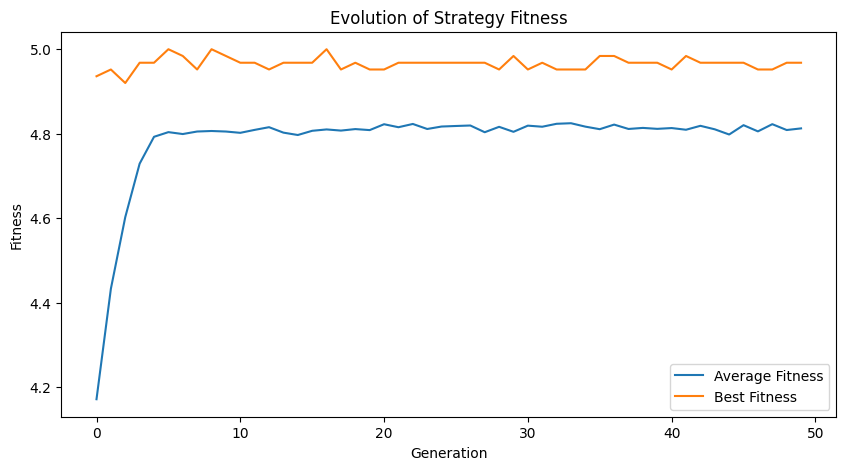

#1 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'D']}, Fitness: 5.000
#2 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'D', 'D', 'D', 'C']}, Fitness: 5.000
#3 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'D', 'D']}, Fitness: 5.000
#4 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D']}, Fitness: 5.000
#5 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'D', 'D', 'D']}, Fitness: 5.000
Best overall solution found in Generation 6 with Fitness: 5.000
Best evolved strategy genome: ['D', 'D', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D']


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Strategy Classes
# ==========================

class Strategy:
    """Base class for all strategies."""
    def make_move(self, history):
        raise NotImplementedError

class AlwaysCooperate(Strategy):
    def make_move(self, history):
        return "C"

class AlwaysDefect(Strategy):
    def make_move(self, history):
        return "D"

class Alternator(Strategy):
    def __init__(self):
        self.last_move = "D"
    def make_move(self, history):
        self.last_move = "C" if self.last_move == "D" else "D"
        return self.last_move

class TitForTat(Strategy):
    def make_move(self, history):
        return "C" if not history else history[-1][1]

class GrimTrigger(Strategy):
    def __init__(self):
        self.defected = False
    def make_move(self, history):
        if self.defected:
            return "D"
        if history and history[-1][1] == "D":
            self.defected = True
            return "D"
        return "C"

class SuspiciousTitForTat(Strategy):
    def make_move(self, history):
        return "D" if not history else history[-1][1]

class Pavlov(Strategy):
    def make_move(self, history):
        if not history:
            return "C"
        last_own, last_opponent = history[-1]
        return last_own if last_own == last_opponent else ("C" if last_own == "D" else "D")

# ==========================
# Prisoner's Dilemma Simulation
# ==========================

def play_ipd(strategy1, strategy2, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    score1, score2 = 0, 0
    history = []
    for _ in range(rounds):
        move1 = decide_move(strategy1, history, memory_length, player_idx=1)
        move2 = decide_move(strategy2, history, memory_length, player_idx=2)
        
        # Apply noise only to GA-evolved strategies (i.e., those not instances of Strategy)
        if noise:
            if not isinstance(strategy1, Strategy) and random.random() < noise_prob:
                move1 = "D" if move1 == "C" else "C"
            if not isinstance(strategy2, Strategy) and random.random() < noise_prob:
                move2 = "D" if move2 == "C" else "C"
        
        s1, s2 = payoff(move1, move2)
        score1 += s1
        score2 += s2
        history.append((move1, move2))
        if len(history) > memory_length:
            history.pop(0)
    return score1, score2

def decide_move(strategy, shared_history, memory_length, player_idx):
    perspective = []
    for (m1, m2) in shared_history:
        if player_idx == 1:
            perspective.append((m1, m2))
        else:
            perspective.append((m2, m1))
    if isinstance(strategy, Strategy):
        return strategy.make_move(perspective)
    else:
        index = strategy_lookup(perspective, memory_length)
        return strategy["genome"][index]

def strategy_lookup(history, memory_length):
    if len(history) < memory_length:
        return 0
    relevant = history[-memory_length:]
    binary_str = "".join("1" if move == "C" else "0"
                         for round_moves in relevant for move in round_moves)
    return int(binary_str, 2) + 1

def payoff(move1, move2):
    PAYOFF_MATRIX = {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 5),
        ("D", "C"): (5, 0),
        ("D", "D"): (1, 1)
    }
    return PAYOFF_MATRIX[(move1, move2)]

# ==========================
# Genetic Algorithm Components
# ==========================

def initialize_population(pop_size, memory_length):
    genome_size = 2 ** (2 * memory_length) + 1
    population = []
    for _ in range(pop_size):
        individual = {
            "type": "binary",
            "genome": [random.choice(["C", "D"]) for _ in range(genome_size)]
        }
        population.append(individual)
    return population

def fitness(strategy, opponents, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    total_score = 0
    max_possible_score = rounds * 5
    for opponent in opponents:
        score1, _ = play_ipd(strategy, opponent, rounds, memory_length, noise, noise_prob)
        total_score += score1
    normalized_fitness = total_score / (len(opponents) * max_possible_score)
    return 1 + 4 * normalized_fitness

def mutate(strategy):
    genome = strategy["genome"].copy()
    for i in range(len(genome)):
        if random.random() < 0.1:
            genome[i] = "C" if genome[i] == "D" else "D"
    return {"type": "binary", "genome": genome}

def crossover(parent1, parent2):
    genome1, genome2 = parent1["genome"], parent2["genome"]
    split = random.randint(1, len(genome1) - 1)
    child1 = {"type": "binary", "genome": genome1[:split] + genome2[split:]}
    child2 = {"type": "binary", "genome": genome2[:split] + genome1[split:]}
    return child1, child2

def tournament_selection(population, fitness_scores, tournament_size=8):
    selected_parents = []
    for _ in range(len(population) // 2):
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = max(tournament, key=lambda pair: pair[1])
        selected_parents.append(winner[0])
    return selected_parents

def genetic_algorithm(pop_size=100, generations=100, mutation_rate=0.1, crossover_rate=0.2,
                      rounds=100, memory_length=2, opponents=None, tournament_size=3, noise=False, noise_prob=0.1):
    if opponents is None:
        opponents = [
            AlwaysCooperate(), AlwaysDefect(), Alternator(),
            TitForTat(), GrimTrigger(), SuspiciousTitForTat(), Pavlov()
        ]
    
    population = initialize_population(pop_size, memory_length)
    avg_fitness_progression = []
    best_fitness_progression = []

    best_overall_fitness = -float('inf')
    best_overall_strategy = None
    best_overall_generation = -1

    for generation in range(generations):
        fitness_scores = [fitness(ind, opponents, rounds, memory_length, noise, noise_prob) for ind in population]
        avg_fit = np.mean(fitness_scores)
        best_fit = max(fitness_scores)
        avg_fitness_progression.append(avg_fit)
        best_fitness_progression.append(best_fit)

        current_best_idx = np.argmax(fitness_scores)
        if fitness_scores[current_best_idx] > best_overall_fitness:
            best_overall_fitness = fitness_scores[current_best_idx]
            best_overall_strategy = population[current_best_idx]
            best_overall_generation = generation + 1

        if generation % 10 == 0:
            print(f"Generation {generation + 1} - Best Fitness: {best_fit:.3f} - Avg Fitness: {avg_fit:.3f}")

        parents = tournament_selection(population, fitness_scores, tournament_size)
        offspring = []
        for i in range(0, len(parents) - 1, 2):
            p1, p2 = parents[i], parents[i+1]
            if random.random() < crossover_rate:
                child1, child2 = crossover(p1, p2)
            else:
                child1, child2 = p1.copy(), p2.copy()
            if random.random() < mutation_rate:
                child1 = mutate(child1)
            if random.random() < mutation_rate:
                child2 = mutate(child2)
            offspring.append(child1)
            offspring.append(child2)
        population = parents + offspring
        population = population[:pop_size]
        best_individual = max(zip(population, fitness_scores), key=lambda pair: pair[1])[0]
        population[0] = best_individual

    plt.figure(figsize=(10, 5))
    plt.plot(avg_fitness_progression, label="Average Fitness")
    plt.plot(best_fitness_progression, label="Best Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Strategy Fitness")
    plt.legend()
    plt.show()

    final_fitness_scores = [fitness(ind, opponents, rounds, memory_length) for ind in population]
    sorted_pop = sorted(zip(population, final_fitness_scores), key=lambda x: x[1], reverse=True)
    best_strategies = sorted_pop[:5]

    for i, (strat, score) in enumerate(best_strategies, start=1):
        print(f"#{i} Strategy: {strat}, Fitness: {score:.3f}")

    print(f"Best overall solution found in Generation {best_overall_generation} with Fitness: {best_overall_fitness:.3f}")
    return best_overall_strategy

# ==========================
# Main Execution Example
# ==========================

if __name__ == "__main__":
    opponents = [AlwaysCooperate()]
    best_strategy = genetic_algorithm(
        pop_size=500,
        generations=50,
        mutation_rate=0.4,
        crossover_rate=0.6,
        rounds=100,
        memory_length=2,
        opponents=opponents,
        noise=True,
        noise_prob=0.1
    )
    print("Best evolved strategy genome:", best_strategy["genome"])

Generation 1 - Best Fitness: 4.456 - Avg Fitness: 4.201
Generation 11 - Best Fitness: 4.440 - Avg Fitness: 4.199
Generation 21 - Best Fitness: 4.440 - Avg Fitness: 4.203
Generation 31 - Best Fitness: 4.488 - Avg Fitness: 4.201
Generation 41 - Best Fitness: 4.456 - Avg Fitness: 4.205


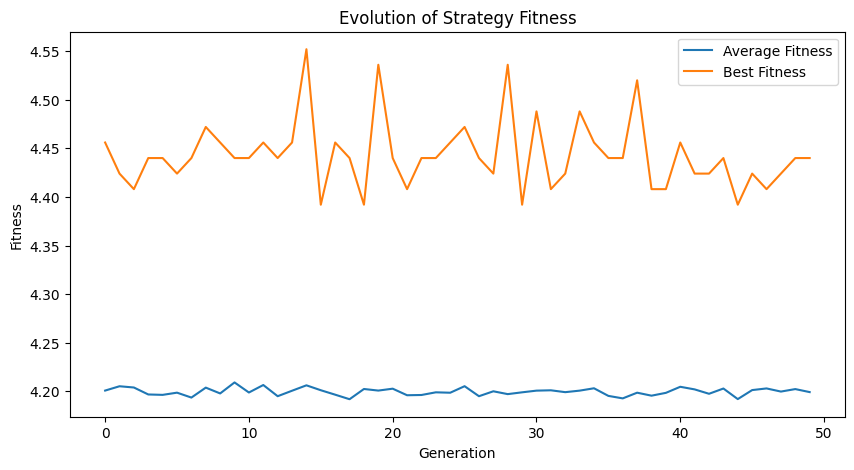

#1 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'D', 'C', 'C', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'C', 'C', 'D']}, Fitness: 5.000
#2 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'C', 'C', 'C', 'C', 'D', 'C', 'C', 'C', 'C', 'D', 'C', 'D', 'D', 'C', 'D']}, Fitness: 5.000
#3 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'D', 'C', 'C', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'C', 'C', 'D', 'C', 'C']}, Fitness: 5.000
#4 Strategy: {'type': 'binary', 'genome': ['D', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'C', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C']}, Fitness: 5.000
#5 Strategy: {'type': 'binary', 'genome': ['D', 'C', 'C', 'C', 'C', 'D', 'D', 'C', 'C', 'C', 'D', 'C', 'C', 'C', 'C', 'D', 'C']}, Fitness: 5.000
Best overall solution found in Generation 15 with Fitness: 4.552
Best evolved strategy genome: ['D', 'C', 'C', 'D', 'D', 'D', 'C', 'D', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C']


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ==========================
# Strategy Classes
# ==========================

class Strategy:
    """Base class for all strategies."""
    def make_move(self, history):
        raise NotImplementedError

class AlwaysCooperate(Strategy):
    def make_move(self, history):
        return "C"

class AlwaysDefect(Strategy):
    def make_move(self, history):
        return "D"

class Alternator(Strategy):
    def __init__(self):
        self.last_move = "D"
    def make_move(self, history):
        self.last_move = "C" if self.last_move == "D" else "D"
        return self.last_move

class TitForTat(Strategy):
    def make_move(self, history):
        return "C" if not history else history[-1][1]

class GrimTrigger(Strategy):
    def __init__(self):
        self.defected = False
    def make_move(self, history):
        if self.defected:
            return "D"
        if history and history[-1][1] == "D":
            self.defected = True
            return "D"
        return "C"

class SuspiciousTitForTat(Strategy):
    def make_move(self, history):
        return "D" if not history else history[-1][1]

class Pavlov(Strategy):
    def make_move(self, history):
        if not history:
            return "C"
        last_own, last_opponent = history[-1]
        return last_own if last_own == last_opponent else ("C" if last_own == "D" else "D")

# ==========================
# Prisoner's Dilemma Simulation
# ==========================

def play_ipd(strategy1, strategy2, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    score1, score2 = 0, 0
    history = []
    for _ in range(rounds):
        move1 = decide_move(strategy1, history, memory_length, player_idx=1)
        move2 = decide_move(strategy2, history, memory_length, player_idx=2)
        
        # Apply noise only to GA-evolved strategies (i.e., those not instances of Strategy)
        if noise:
            if not isinstance(strategy1, Strategy) and random.random() < noise_prob:
                move1 = "D" if move1 == "C" else "C"
            if not isinstance(strategy2, Strategy) and random.random() < noise_prob:
                move2 = "D" if move2 == "C" else "C"
        
        s1, s2 = payoff(move1, move2)
        score1 += s1
        score2 += s2
        history.append((move1, move2))
        if len(history) > memory_length:
            history.pop(0)
    return score1, score2

def decide_move(strategy, shared_history, memory_length, player_idx):
    perspective = []
    for (m1, m2) in shared_history:
        if player_idx == 1:
            perspective.append((m1, m2))
        else:
            perspective.append((m2, m1))
    if isinstance(strategy, Strategy):
        return strategy.make_move(perspective)
    else:
        index = strategy_lookup(perspective, memory_length)
        return strategy["genome"][index]

def strategy_lookup(history, memory_length):
    if len(history) < memory_length:
        return 0
    relevant = history[-memory_length:]
    binary_str = "".join("1" if move == "C" else "0"
                         for round_moves in relevant for move in round_moves)
    return int(binary_str, 2) + 1

def payoff(move1, move2):
    PAYOFF_MATRIX = {
        ("C", "C"): (3, 3),
        ("C", "D"): (0, 5),
        ("D", "C"): (5, 0),
        ("D", "D"): (1, 1)
    }
    return PAYOFF_MATRIX[(move1, move2)]

# ==========================
# Genetic Algorithm Components
# ==========================

def initialize_population(pop_size, memory_length):
    genome_size = 2 ** (2 * memory_length) + 1
    population = []
    for _ in range(pop_size):
        individual = {
            "type": "binary",
            "genome": [random.choice(["C", "D"]) for _ in range(genome_size)]
        }
        population.append(individual)
    return population

def fitness(strategy, opponents, rounds=100, memory_length=1, noise=False, noise_prob=0.1):
    total_score = 0
    max_possible_score = rounds * 5
    for opponent in opponents:
        score1, _ = play_ipd(strategy, opponent, rounds, memory_length, noise, noise_prob)
        total_score += score1
    normalized_fitness = total_score / (len(opponents) * max_possible_score)
    return 1 + 4 * normalized_fitness

def mutate(strategy):
    genome = strategy["genome"].copy()
    for i in range(len(genome)):
        if random.random() < 0.1:
            genome[i] = "C" if genome[i] == "D" else "D"
    return {"type": "binary", "genome": genome}

def crossover(parent1, parent2):
    genome1, genome2 = parent1["genome"], parent2["genome"]
    split = random.randint(1, len(genome1) - 1)
    child1 = {"type": "binary", "genome": genome1[:split] + genome2[split:]}
    child2 = {"type": "binary", "genome": genome2[:split] + genome1[split:]}
    return child1, child2

def tournament_selection(population, fitness_scores, tournament_size=8):
    selected_parents = []
    for _ in range(len(population) // 2):
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = max(tournament, key=lambda pair: pair[1])
        selected_parents.append(winner[0])
    return selected_parents

def genetic_algorithm(pop_size=100, generations=100, mutation_rate=0.1, crossover_rate=0.2,
                      rounds=100, memory_length=2, opponents=None, tournament_size=3, noise=False, noise_prob=0.1):
    if opponents is None:
        opponents = [
            AlwaysCooperate(), AlwaysDefect(), Alternator(),
            TitForTat(), GrimTrigger(), SuspiciousTitForTat(), Pavlov()
        ]
    
    population = initialize_population(pop_size, memory_length)
    avg_fitness_progression = []
    best_fitness_progression = []

    best_overall_fitness = -float('inf')
    best_overall_strategy = None
    best_overall_generation = -1

    for generation in range(generations):
        fitness_scores = [fitness(ind, opponents, rounds, memory_length, noise, noise_prob) for ind in population]
        avg_fit = np.mean(fitness_scores)
        best_fit = max(fitness_scores)
        avg_fitness_progression.append(avg_fit)
        best_fitness_progression.append(best_fit)

        current_best_idx = np.argmax(fitness_scores)
        if fitness_scores[current_best_idx] > best_overall_fitness:
            best_overall_fitness = fitness_scores[current_best_idx]
            best_overall_strategy = population[current_best_idx]
            best_overall_generation = generation + 1

        if generation % 10 == 0:
            print(f"Generation {generation + 1} - Best Fitness: {best_fit:.3f} - Avg Fitness: {avg_fit:.3f}")

        parents = tournament_selection(population, fitness_scores, tournament_size)
        offspring = []
        for i in range(0, len(parents) - 1, 2):
            p1, p2 = parents[i], parents[i+1]
            if random.random() < crossover_rate:
                child1, child2 = crossover(p1, p2)
            else:
                child1, child2 = p1.copy(), p2.copy()
            if random.random() < mutation_rate:
                child1 = mutate(child1)
            if random.random() < mutation_rate:
                child2 = mutate(child2)
            offspring.append(child1)
            offspring.append(child2)
        population = parents + offspring
        population = population[:pop_size]
        best_individual = max(zip(population, fitness_scores), key=lambda pair: pair[1])[0]
        population[0] = best_individual

    plt.figure(figsize=(10, 5))
    plt.plot(avg_fitness_progression, label="Average Fitness")
    plt.plot(best_fitness_progression, label="Best Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Strategy Fitness")
    plt.legend()
    plt.show()

    final_fitness_scores = [fitness(ind, opponents, rounds, memory_length) for ind in population]
    sorted_pop = sorted(zip(population, final_fitness_scores), key=lambda x: x[1], reverse=True)
    best_strategies = sorted_pop[:5]

    for i, (strat, score) in enumerate(best_strategies, start=1):
        print(f"#{i} Strategy: {strat}, Fitness: {score:.3f}")

    print(f"Best overall solution found in Generation {best_overall_generation} with Fitness: {best_overall_fitness:.3f}")
    return best_overall_strategy

# ==========================
# Main Execution Example
# ==========================

if __name__ == "__main__":
    opponents = [AlwaysCooperate()]
    best_strategy = genetic_algorithm(
        pop_size=500,
        generations=50,
        mutation_rate=0.4,
        crossover_rate=0.6,
        rounds=100,
        memory_length=2,
        opponents=opponents,
        noise=True,
        noise_prob=0.5
    )
    print("Best evolved strategy genome:", best_strategy["genome"])